# Test install libraries

In [1]:
import glob, os, subprocess
import datetime

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx
from pathlib import Path

import rasterio
import rasterio.plot
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio import features

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np

import rasterstats
from rasterstats import zonal_stats

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.offline

from collections import defaultdict


import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.datasets import make_classification

from skimage import data

import osmnx as ox

from bokeh.plotting import figure, show

import folium

import ee

from osgeo import gdal

print(cx.__version__)
print(plotly.__version__)
print(rasterstats.__version__)

1.2.0
5.11.0
0.18.0


### Test ``osmnx``

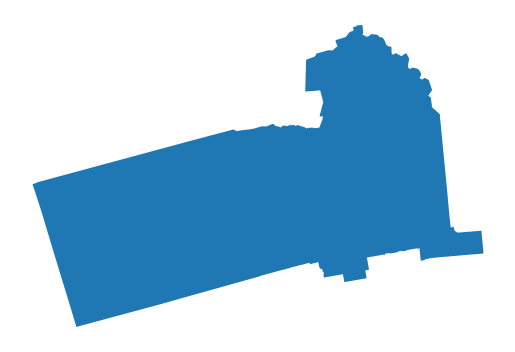

In [2]:
city = ox.geocode_to_gdf('Berkeley, California')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')

### Test ``bokeh``

In [3]:
# prepare some data
x = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

# create a new plot with a title and axis labels
p = figure(title="Multiple glyphs example", x_axis_label="x", y_axis_label="y")

# add multiple renderers
p.line(x, y1, legend_label="Temp.", color="#004488", line_width=3)
p.line(x, y2, legend_label="Rate", color="#906c18", line_width=3)
p.circle(x, y3, legend_label="Objects", color="#bb5566", size=16)

# show the results
show(p)

### Test ``folium``

In [4]:
m = folium.Map(location=[45.5236, -122.6750])
m

### Test ``skimage``

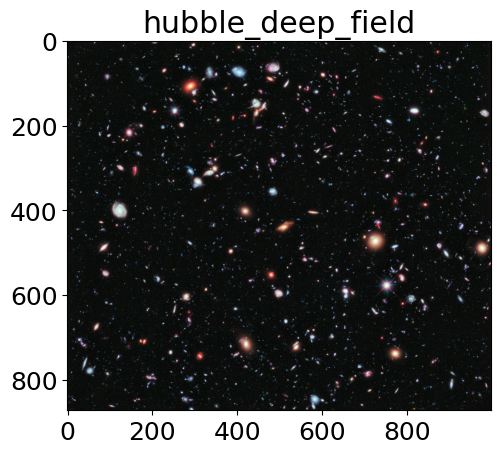

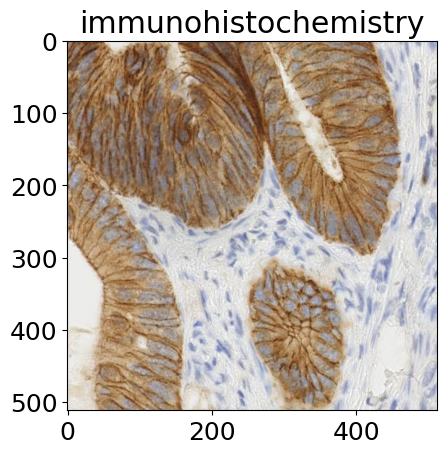

In [5]:
matplotlib.rcParams['font.size'] = 18

images = ('hubble_deep_field',
          'immunohistochemistry')


for name in images:
    caller = getattr(data, name)
    image = caller()
    plt.figure()
    plt.title(name)
    if image.ndim == 2:
        plt.imshow(image, cmap=plt.cm.gray)
    else:
        plt.imshow(image)

plt.show()

## Set some data to test the following libraries

In [6]:
path = 'X:/data/TEST/'
path = 'R:/data/TEST/'

output_path = f'{path}OUTPUT/'

im_input  = f'{path}T31UFS_20200719T105031_NDVI.tif'
im_output = f'{output_path}T31UFS_20200719T105031_NDVI_x10.tif'

vec_input  = f'{path}NAMUR_2020_IN_SITU_ROI_prepared.shp'

Path(output_path).mkdir(parents=True, exist_ok=True)

### Test ``gdal``

In [7]:
dataset = gdal.Open(im_input, gdal.GA_ReadOnly)

band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Band Type=Float64
Min=-0.977, Max=0.999


### Test ``geopandas`` and ``contextily``

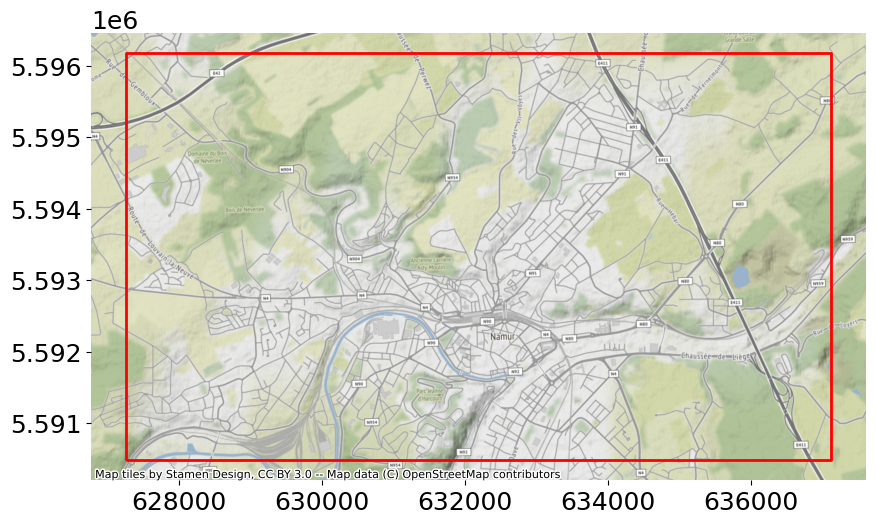

In [8]:
crs_dst = 'EPSG:32631'
roi_name = 'extent_roi_4tiles'
roi_filename = f'{roi_name}_{crs_dst[5:]}.shp'
roi_file = f'{output_path}{roi_filename}'

crs_src = 'EPSG:32631'
bbox    = [627263.7,5590485.2,637115,5596175.1]
ulx = bbox[0]
uly = bbox[1]
lrx = bbox[2]
lry = bbox[3]

# Create a list with the longitude coordinates (x)
lon_point_list = [ulx, lrx, lrx, ulx, ulx]
# Create a list with the latitude coordinates (y)
lat_point_list = [uly, uly, lry, lry, uly]
# Create a polygon object from the two list (lon and lat)
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
# Create a GeoDataFrame with the polygon object
gdf = gpd.GeoDataFrame(index=[0], crs=crs_src, geometry=[polygon_geom])       
# Reproject the GeoDataFrame to the destination CRS (needed only if you set your coordinates in WGS 84)
gdf = gdf.to_crs(crs_dst)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

gdf.boundary.plot(ax=ax,
                  color='red',
                  linewidth=2)

cx.add_basemap(ax, crs=gdf.crs.to_string())

plt.box(False)

In [17]:
print(roi_file)

gdf.to_file(filename=roi_file, driver='ESRI Shapefile')

R:/data/TEST/OUTPUT/extent_roi_4tiles_32631.shp


### Test ``plotly``

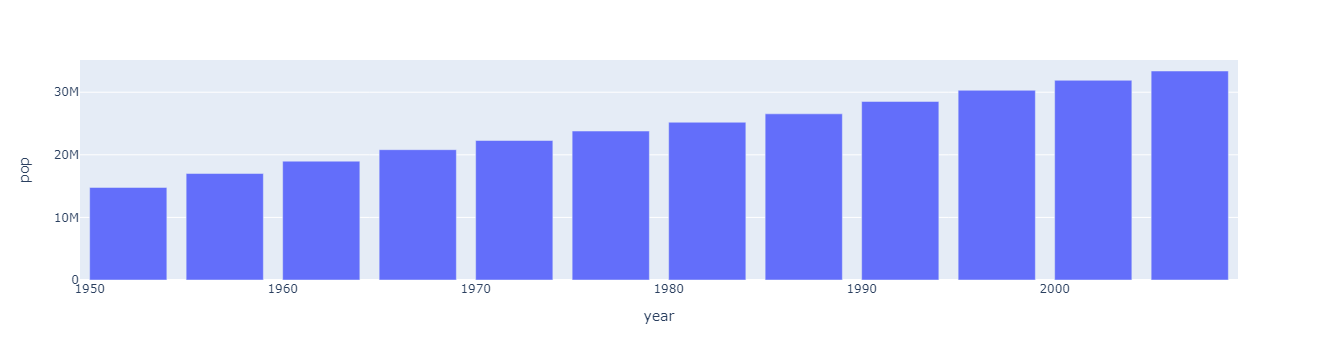

In [10]:
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

### Test ``rasterio``

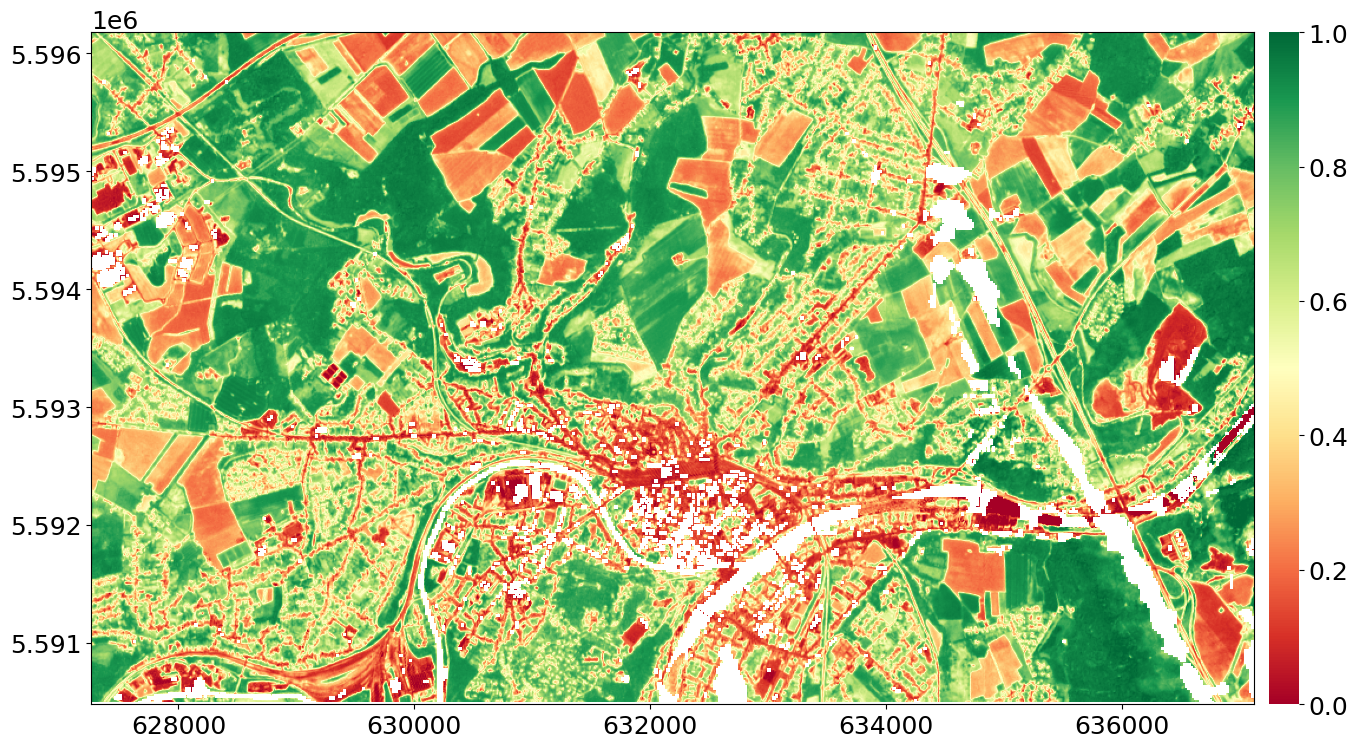

In [11]:
# Create a figure object
fig, ax = plt.subplots(1, 1, figsize=(15,15))

# Open image with rasterio
src = rasterio.open(im_input, "r")

# Get color map with matplotlib
color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

# Plot image
im_rio = rasterio.plot.show(src,
                            cmap=color_map,
                            vmin=0,
                            vmax=1,
                            ax=ax)

im_rio = im_rio.get_images()[0]

# Add color bar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)


plt.box(False)

### Test ``rasterstats``

In [12]:
src = rasterio.open(im_input, "r")
im_arr = src.read(1)
nodata_val = -10000

gdf = gpd.read_file(vec_input)


# Get transform from profile (metadata)
profile = src.profile
transform = profile['transform']

df = pd.DataFrame(zonal_stats(gdf,
                                im_arr,
                                affine=transform,
                                stats=['count','nodata','mean','std'],
                                nodata=nodata_val,
                                ))

df

mean  count       std  nodata
0    0.493047     17  0.041720     0.0
1    0.910484    146  0.031384     0.0
2    0.895426     18  0.018982     0.0
3    0.488354     79  0.031562     0.0
4    0.828976     39  0.094717     0.0
..        ...    ...       ...     ...
532  0.937661     64  0.007761     0.0
533  0.913241     65  0.009943     0.0
534  0.950251     14  0.010176     0.0
535  0.871728     82  0.061402     0.0
536  0.924402     47  0.009952     0.0

[537 rows x 4 columns]

### Test ``sklearn``

In [13]:
X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
RandomForestClassifier(...)
print(clf.predict([[0, 0, 0, 0]]))

[1]


### Test ``otb``

In [14]:
import otbApplication as otb

app = otb.Registry.CreateApplication("BandMath")

app.SetParameterStringList("il", [im_input])
app.SetParameterString("out", im_output)
app.SetParameterString("exp", "im1b1 * 10")

app.ExecuteAndWriteOutput()

ModuleNotFoundError: No module named 'otbApplication'

### Test ``Earth Engine Python API``

In [15]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  v


KeyError: 'client_id'